In [24]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
import sklearn
import random
import time
import scipy
import datetime
import imblearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection  import ParameterGrid
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

from sklearn.metrics import accuracy_score, mean_squared_error

seed = 983

## Import data and test data pre-processed

In [25]:
data=pd.read_csv('pre_processed_data.csv')
data = data.drop('Unnamed: 0', axis =1)

data_test=pd.read_csv('pre_processed_data_test.csv')
data_test = data_test.drop('Unnamed: 0', axis =1)

Finish the pre-processing:

In [26]:
y = data['LOS']

numericals = ['HeartRate_Min','HeartRate_Max','HeartRate_Mean','SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'age', 'com_prob']

categoricals = ['ADMISSION_TYPE', 'FIRST_CAREUNIT', 'GENDER', 'ETHNICS',
                'RELIGION', 'INSURANCE','NIGHT', 'WEEKDAY', 'SEASON', 'DIAG', 'HOLIDAY']
#Notice DIAG and com_prob do not exist yet, they will be added in the following steps

variables = numericals + categoricals

# Categorical encoding so that the code runs
for n in [i for i in categoricals if i != 'DIAG']:
    dict = data.groupby(n)['HOSPITAL_EXPIRE_FLAG'].mean().to_dict()  
    data[n] = data[n].apply(lambda x: dict[x])
    data_test[n] = data_test[n].apply(lambda x: dict[x])
    

diag_mean_dict = data.groupby('ICD9_diagnosis')['HOSPITAL_EXPIRE_FLAG'].mean().to_dict()

def get_diag(x):
    if x in diag_mean_dict:
        return diag_mean_dict[x]
    else: 
        return data.HOSPITAL_EXPIRE_FLAG.mean()

data['DIAG'] = data['ICD9_diagnosis'].apply(get_diag)
data_test['DIAG'] = data_test['ICD9_diagnosis'].apply(get_diag)

data['com_prob'] = data.sort_values(['subject_id', 'ADMITTIME']).groupby('subject_id')['DIAG'].cumsum()

data_test['com_prob']=data_test.sort_values(['subject_id', 'ADMITTIME']).groupby('subject_id')['DIAG'].cumsum()

X_train = data[variables]
X_test = data_test[variables]

X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Dealing with Outliers and NAs

For dealing with outliers, I tried to delete all the rows with at one outlier in any column. I defined as an outlier a value falling below the 0.1 quantile and above the 0.9. I applied this code only to the numerical categoricals and then tried to run XBoost, ensables and random forest but none of them gave me a better result. I had 19437 rows, a big reduction. Almost 10% of the data.

I attach here how I got the data without the outliers (this code will not run because I don't want to change this data beacuse if you want to run this model, I would like it better with the original data).

[Text(1, 0, 'HeartRate_Min'),
 Text(2, 0, 'HeartRate_Max'),
 Text(3, 0, 'HeartRate_Mean'),
 Text(4, 0, 'SysBP_Min'),
 Text(5, 0, 'SysBP_Max'),
 Text(6, 0, 'SysBP_Mean'),
 Text(7, 0, 'DiasBP_Min'),
 Text(8, 0, 'DiasBP_Max'),
 Text(9, 0, 'DiasBP_Mean'),
 Text(10, 0, 'MeanBP_Min'),
 Text(11, 0, 'MeanBP_Max'),
 Text(12, 0, 'MeanBP_Mean'),
 Text(13, 0, 'RespRate_Min'),
 Text(14, 0, 'RespRate_Max'),
 Text(15, 0, 'RespRate_Mean'),
 Text(16, 0, 'TempC_Min'),
 Text(17, 0, 'TempC_Max'),
 Text(18, 0, 'TempC_Mean'),
 Text(19, 0, 'SpO2_Min'),
 Text(20, 0, 'SpO2_Max'),
 Text(21, 0, 'SpO2_Mean'),
 Text(22, 0, 'Glucose_Min'),
 Text(23, 0, 'Glucose_Max'),
 Text(24, 0, 'Glucose_Mean'),
 Text(25, 0, 'age'),
 Text(26, 0, 'com_prob')]

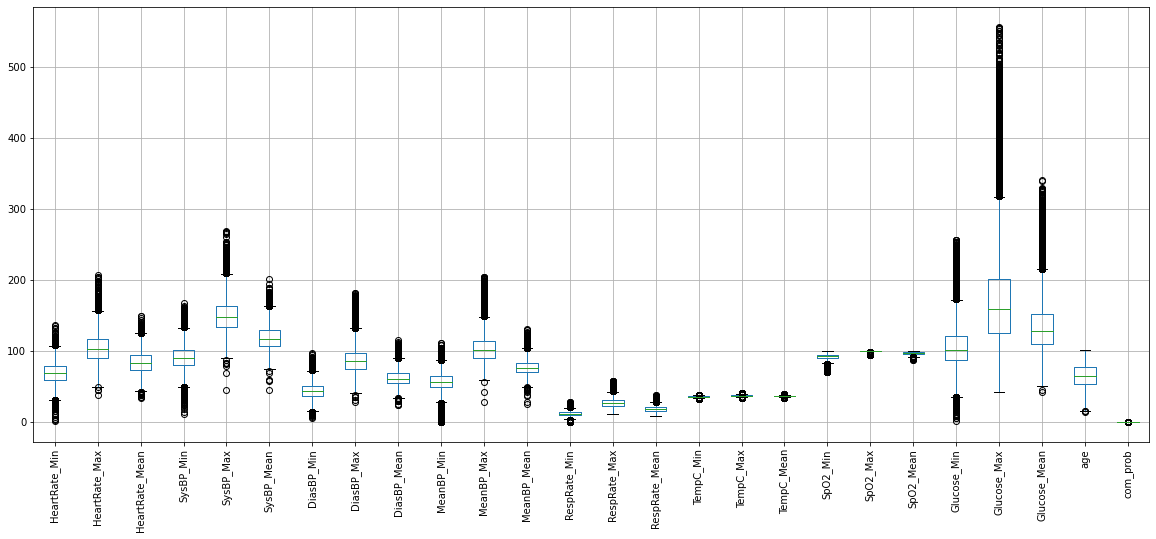

In [18]:
boxplot = df_out.boxplot(column = numericals, figsize=(20,8))
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)

In [14]:
#Count how many there are
Q1 = data[numericals].quantile(0.1)
Q3 = data[numericals].quantile(0.9)
IQR = Q3 - Q1

df_out = data[~((data[numericals] < (Q1 - 1.5 * IQR)) |(data[numericals] > (Q3 + 1.5 * IQR))).any(axis=1)]

For NA values, I tried removing, them substitute them by median, mean and I also tried to do it by KNN but it did not have a good accuracy. This code won't run either

In [17]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=100, weights='distance')

numericals_with_na  = ['Glucose_Mean', 'Glucose_Max', 'Glucose_Min', 'HeartRate_Min','HeartRate_Max','HeartRate_Mean',
         'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',
         'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
         'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean']

columns = ['Glucose_Mean', 'Glucose_Max', 'Glucose_Min', 'HeartRate_Min','HeartRate_Max','HeartRate_Mean',
         'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',
         'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
         'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean']

#variables with NA's in order (first the ones with fewer NA's)
for n in numericals_with_na:

    x_trainNN = X_train[X_train[n].notnull()].drop(columns, axis =1)
    y_trainNN = X_train[X_train[n].notnull()][n]
    x_train_missing = X_train[X_train[n].isnull()].drop(columns, axis =1)
    y_train_missing = X_train[X_train[n].isnull()][n]

    x_test_missing = X_test[X_test[n].isnull()].drop(columns, axis =1)
    y_test_missing = X_test[X_test[n].isnull()][n]

    # scale before running model
    from sklearn import preprocessing
    scaler = preprocessing.StandardScaler(with_mean=True, with_std=True).fit(x_trainNN)
    x_trainNN= scaler.transform(x_trainNN)
    x_train_missing=scaler.transform(x_train_missing)
    x_test_missing=scaler.transform(x_test_missing)

    #Train the KNN
    knn.fit(x_trainNN, y_trainNN)

    #Predict the missing values for both X_train and X_test.
    predicted_train = knn.predict(x_train_missing)
    predicted_test = knn.predict(x_test_missing)
    
    #Insert the predictions into the data sets
    X_train.loc[X_train[n].isnull(), n] = predicted_train
    X_test.loc[X_test[n].isnull(), n] = predicted_test
    
    columns.remove(n)

ValueError: Found array with 0 sample(s) (shape=(0, 13)) while a minimum of 1 is required by StandardScaler.

### Variable corraltions


As we can see the correlated ones are the numeric variables (mean, min and max). So I tried doing it with the mean only and the result was not good.

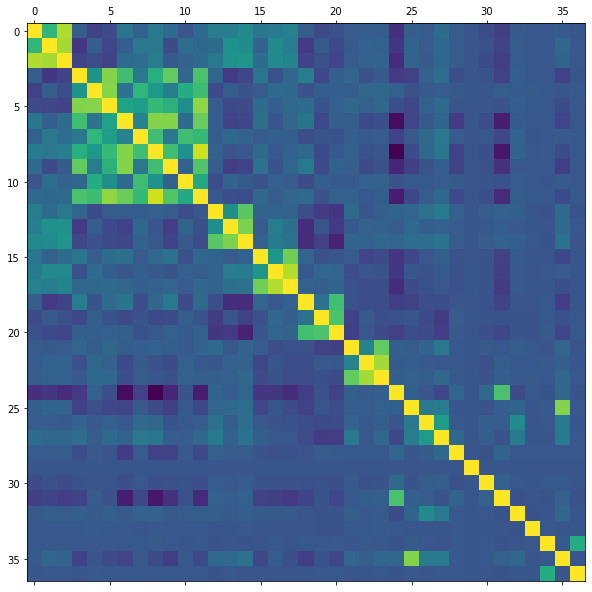

In [36]:
import matplotlib.pyplot as plt

plt.matshow(X_train.corr())
plt.show()

### Ada Boost

In [27]:
model = AdaBoostRegressor()

grid_values = {'n_estimators': [100, 200],
                'random_state': [seed],
                'learning_rate': [0.1]
}


grid_ab_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_ab_acc.fit(X_train, y)

y_pred_acc = grid_ab_acc.predict(X_test)

print("MSE::{}".format(grid_ab_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_ab_acc.best_params_))

MSE::-38.913396492263516
Best Hyperparameters::
{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 983}


### Decision tree

In [28]:
model = DecisionTreeRegressor(min_samples_split=5, max_features= 'auto')

grid_values = {'criterion': ['mse'],
              'splitter': ['best', 'random'],
              'max_depth': [3],
              'min_samples_leaf': [20,50],
              'max_leaf_nodes': [50,100]
              }


grid_dt_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_dt_acc.fit(X_train,y)

y_pred_acc = grid_dt_acc.predict(X_test)

print("MSE::{}".format(grid_dt_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_dt_acc.best_params_))

MSE::-25.453404007991942
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 3, 'max_leaf_nodes': 50, 'min_samples_leaf': 50, 'splitter': 'best'}


### Simple Random Forest

In [37]:
%%time

model = RandomForestRegressor(random_state=38)


grid_values = {'n_estimators': [150],
            'max_features': ['auto', 'log2'],
            'max_depth' : [3],
            'criterion' :['mse']
}

grid_rf_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_rf_acc.fit(X_train,y)

y_pred_acc = grid_rf_acc.predict(X_test)

print("Best MSE::\n{}".format(grid_rf_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_rf_acc.best_params_))

KeyboardInterrupt: 

### XGBoost with selection variable from Random Forest

In [43]:
# Run Random forest to get the importance of the features and then proceed to the selection

model = RandomForestRegressor(random_state=38)


grid_values = {'n_estimators': [150],
            'max_features': ['auto', 'log2'],
            'max_depth' : [3],
            'criterion' :['mse']
}

grid_rf_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_rf_acc.fit(X_train,y)

y_pred_acc = grid_rf_acc.predict(X_test)

print("Best MSE::\n{}".format(grid_rf_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_rf_acc.best_params_))

Best MSE::
-25.16854916017236
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 150}


In [44]:
importances = grid_rf_acc.best_estimator_.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=X_train.columns).sort_values(ascending=False)
important_features

DIAG              1.000000
TempC_Max         0.449627
SysBP_Min         0.439540
HeartRate_Max     0.328333
Glucose_Max       0.127491
RespRate_Max      0.110397
RespRate_Mean     0.103243
TempC_Mean        0.076598
TempC_Min         0.056820
SysBP_Max         0.033646
HeartRate_Min     0.032717
DiasBP_Min        0.025893
HeartRate_Mean    0.023611
Glucose_Mean      0.019107
age               0.016929
RespRate_Min      0.011415
SpO2_Min          0.009381
SpO2_Mean         0.009322
SpO2_Max          0.008892
DiasBP_Mean       0.006436
MeanBP_Max        0.005961
Glucose_Min       0.004645
MeanBP_Min        0.001548
MeanBP_Mean       0.001387
SEASON            0.000339
FIRST_CAREUNIT    0.000186
SysBP_Mean        0.000138
GENDER            0.000000
ETHNICS           0.000000
ADMISSION_TYPE    0.000000
com_prob          0.000000
DiasBP_Max        0.000000
RELIGION          0.000000
INSURANCE         0.000000
NIGHT             0.000000
WEEKDAY           0.000000
HOLIDAY           0.000000
d

In [45]:
# Selectin the variables over 0.01

columns = important_features.index.tolist()[0:33]

In [47]:
# Run XGBoost to get the prediction


model = XGBRegressor()

grid_values = {
    'n_estimators' : [200,150],
    'learning_rate': [0.1,0.2], #so called `eta` value
    'max_depth': [3],
    'random_state' : [seed],
    'sampling_method': ['uniform', 'gradient_based']
}


grid_xgb_acc = GridSearchCV(model, param_grid = grid_values, cv=5, scoring='neg_mean_squared_error')

grid_xgb_acc.fit(X_train, y)

y_pred_acc = grid_xgb_acc.predict(X_test)

print("MSE::{}".format(grid_xgb_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_xgb_acc.best_params_))

MSE::-23.958214216813186
Best Hyperparameters::
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'random_state': 983, 'sampling_method': 'uniform'}


## Ensambles

In order to validate the preformance of the ensambles I will create a test and train split to be able to evaluate its performance. Otherwise I would be testing its perfomance on a data that has been used to estimate the parameters, therfore being over optimistic.

In [48]:
# Train test split
from sklearn.model_selection import train_test_split

col = X_train.columns

X_train, X_test, y_train, y_test = train_test_split(np.array(X_train),y,test_size=0.7, shuffle=True,random_state=seed)

X_train = pd.DataFrame(X_train)
X_train.columns = col
X_test = pd.DataFrame(X_test)
X_test.columns = col
y_train = pd.Series(y_train)
y_train = pd.Series(y_train)

Running random forest with the new data

In [64]:

model = RandomForestRegressor(random_state=38)


grid_values = {'n_estimators': [100,200,300],
            'max_features': ['auto', 'log2'],
            'max_depth' : [3],
            'criterion' :['mse'],
               'random_state': [seed]
}

grid_rf_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_rf_acc.fit(X_train,y_train)

y_pred_acc = grid_rf_acc.predict(X_test)

print("Best negative MSE::\n{}".format(grid_rf_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_rf_acc.best_params_))

Best negative MSE::
-25.069023046781712
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 200, 'random_state': 983}


Running random forest with the new data

In [65]:


model = XGBRegressor()

grid_values = {
    'n_estimators' : [50,60,70,80],
    'learning_rate': [0.1,0.125,0.15], #so called `eta` value
    'max_depth': [3],
    'random_state' : [seed],
    'sampling_method': ['uniform', 'gradient_based']
}


grid_xgb_acc = GridSearchCV(model, param_grid = grid_values, cv=5, scoring='neg_mean_squared_error')

grid_xgb_acc.fit(X_train, y_train)

y_pred_acc = grid_xgb_acc.predict(X_test)

print("Best negative MSE::{}".format(grid_xgb_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_xgb_acc.best_params_))

Best negative MSE::-24.25387280390455
Best Hyperparameters::
{'learning_rate': 0.125, 'max_depth': 3, 'n_estimators': 50, 'random_state': 983, 'sampling_method': 'uniform'}


In [66]:
# Main code

def get_models():
    #Generate a library of simple models with the hyperparmeters of the best models run above
    xgb = XGBRegressor(learning_rate = 0.125, max_depth = 3, n_estimators =70, 
                       random_state = 54, sampling_method = 'uniform')
    rf = RandomForestRegressor(random_state = 54, criterion = 'mse', max_depth = 3, 
                               max_features = 'log2', n_estimators = 200)

    models = {'XGBoost': xgb,
              'random_forest': rf
             }

    return models


def train_predict(model_list,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    #Fit models in list on training set and return preds
    P = np.zeros((y_test.shape[0], len(model_list))) #rows of the y (predictions) and columns of the models we will test
    P = pd.DataFrame(P) #dataframe wehre we will store the predictions

    cols = list()
    for i, (name, m) in enumerate(models.items()): #i is the index of the model in model.items and name and m the model (look at dic)
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train) #xtrian 
        P.iloc[:, i] = pd.DataFrame(m.predict(X_test)).iloc[:, 0] #store the predictions in the corresponding clumn
        cols.append(name) 
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    # Score model in test set
    print("Scoring models.")
    scores=[]
    for m in P.columns:
        score = mean_squared_error(y, P.loc[:, m]) #score roc auc for the models and stor the score (y is the ytest)
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return P.columns,scores


In [67]:
models = get_models()
P = train_predict(models,X_train,y_train,X_test,y_test)
my_models,my_scores= score_models(P, y_test)

XGBoost... done
random_forest... done
Done.

Scoring models.
XGBoost                   : 24.607
random_forest             : 25.453


In [68]:
# Save results
results=[(model,score) for model,score in zip(my_models,my_scores)]
results

[('XGBoost', 24.606929073128068), ('random_forest', 25.453085615679623)]

In [69]:
# Simple average

AvgPred=pd.DataFrame(P.mean(axis=1),columns=['Avg']) #average among all the collumns (en each row)
my_models3,my_scores3= score_models(AvgPred, y_test)
# Save results
results=results+[(model,score) for model,score in zip(my_models3,my_scores3)]

Scoring models.
Avg                       : 24.667


#### Bagging

Now lets do a more complex one and see it it operates better than the others:

I will try combinations of Random Forest and XGBoost with bootstraps

In [70]:
def test_classification(X_train,X_test,y_train,SEED):
    # Check classification for various parameter settings.

    grid = ParameterGrid({"max_samples": [0.8, 1.0],
                          "bootstrap": [True, False],
                          "bootstrap_features": [True, False]})
    
    results=[]
    
    xgb = XGBRegressor(learning_rate = 0.125, max_depth = 3, n_estimators =165, 
                       random_state = 54, sampling_method = 'uniform')
    rf = RandomForestRegressor(random_state = 38, criterion = 'mse', max_depth = 3, 
                                max_features = 'log2', n_estimators = 150)
    
    for base_estimator in [xgb, rf]:
        print("Computing "+ type(base_estimator).__name__)
        for params in grid:
            out=BaggingRegressor(base_estimator=base_estimator,n_estimators=5,
                              random_state=seed,
                              **params).fit(X_train, y_train).predict(X_test)
            results.append((type(base_estimator).__name__,params,out))
    return results

out=test_classification(X_train,X_test,y_train,seed)

Computing XGBRegressor
Computing RandomForestRegressor


In [71]:
# Compute Probabilities per model
P5=pd.DataFrame()
for i in range(len(out)):
    this_case=[x for x in out[i][2]]
    this_df=pd.DataFrame(this_case, columns=[out[i][0]+str(out[i][1])])
    P5=pd.concat([P5, this_df], axis=1)
P5

,"XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}","XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}","XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}","XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}","XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}","XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}","XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}","XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}","RandomForestRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}","RandomForestRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}","RandomForestRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}","RandomForestRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}","RandomForestRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}","RandomForestRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}","RandomForestRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}","RandomForestRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}"
0,1.113957,1.042898,0.989911,0.576136,0.712986,1.307850,1.082866,0.900887,3.039770,3.004001,2.963048,2.944524,3.096334,3.148559,3.013493,2.958439
1,3.097711,2.745477,2.765995,2.126720,2.523796,2.732519,2.128506,2.397835,4.260385,4.362522,3.920380,4.004203,4.255662,4.373116,3.986195,3.982015
2,3.057070,2.915416,2.582508,2.721751,3.047864,3.202223,3.114827,2.998441,2.968625,2.937620,3.114994,3.139771,2.990306,3.000280,3.260199,3.212589
3,4.627226,4.866072,4.418253,4.193591,4.715074,4.628934,4.549355,4.538219,4.046861,3.934524,3.906249,3.824467,4.073586,4.117369,3.839122,3.987886
4,3.482487,3.501246,3.760978,3.670930,3.557152,3.723592,3.551963,3.435106,3.362930,3.386894,3.406735,3.354140,3.413999,3.337769,3.440210,3.365726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14615,3.308613,2.748526,2.079386,4.395345,3.544950,3.499906,3.856847,2.485919,3.244790,3.185610,3.168678,3.181272,3.226533,3.139706,3.181144,3.097161
14616,4.283308,4.147105,4.764454,4.281301,4.073104,4.079851,3.870143,3.643476,3.644571,3.599069,3.803697,3.709258,3.784763,3.632517,3.849922,3.818377
14617,4.360865,4.475057,4.201414,4.568770,4.053553,4.631456,3.745684,3.921604,4.070827,4.143262,3.978137,3.949657,4.244626,4.330803,3.963063,4.089481
14618,2.959927,3.688679,3.522866,3.794702,3.774795,3.772442,4.009181,5.018768,3.446301,3.516499,3.638899,3.652238,3.458815,3.370276,3.677261,3.597650


In [72]:
my_models5,my_scores5= score_models(P5, y_test)

Scoring models.
XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}: 24.474
XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}: 24.498
XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}: 24.421
XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}: 24.528
XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}: 24.489
XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}: 24.450
XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}: 24.597
XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}: 24.870
RandomForestRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}: 25.558
RandomForestRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}: 25.559
RandomForestRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_sam

In [73]:
results=results+[(model,score) for model,score in zip(my_models5,my_scores5)]

#### Stacking
Lets now try the stacking ensable method. Stacking combines differnt models and fits them on the same data frame, in stead of samples on the training data set and will try to combine the models in the best possible way.
In order to do it I will define a metalearner and applying it to differnt models, both XGBoost and Random Forest, I have used differnt types: 
   + Random Forest Regressor
   + XGBoost
   + Extra Trees
   
The best metalearner has been so far XGBoost so it is the one I put here.

In [74]:
# Define the meta learner
meta_learner = XGBRegressor(n_estimators=100,
                                    max_depth = 3,
                                    random_state=seed)


In [75]:
## Define the stacking of our ensamble

# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(folds=5,
                random_state = seed,
                verbose=2,
                backend="threading",
                n_jobs=3
)

# Add the base learners and the meta learner
sl.add(list(models.values()))
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
p_sl = sl.predict(X_test)
scoreStackXtres=mean_squared_error(y_test, p_sl)
print("\nSuper Learner MSE score: %.3f" % scoreStackXtres)


Fitting 2 layers
Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:07

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00

Super Learner MSE score: 26.055


In [76]:
# Finally lets add the result into the previous results

results=results+[('StackingXGBoost',scoreStackXtres)]
results

[('XGBoost', 24.606929073128068),
 ('random_forest', 25.453085615679623),
 ('Avg', 24.66682817053138),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}",
  24.474065829041404),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}",
  24.497796817018333),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}",
  24.421294778162302),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}",
  24.52768221396695),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}",
  24.489113608463626),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}",
  24.45031000992635),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}",
  24.597478081598936),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}",
  24.86958384628135),
 ("RandomForestRegressor{'bo

In [77]:
results_df=pd.DataFrame(results)
results_df.columns=['Method','MSE']
results_df= results_df.sort_values(by='MSE', ascending=True)
results_df.head()

,Method,MSE
5,"XGBRegressor{'bootstrap': True, 'bootstrap_fea...",24.421295
8,"XGBRegressor{'bootstrap': False, 'bootstrap_fe...",24.450310
3,"XGBRegressor{'bootstrap': True, 'bootstrap_fea...",24.474066
7,"XGBRegressor{'bootstrap': False, 'bootstrap_fe...",24.489114
4,"XGBRegressor{'bootstrap': True, 'bootstrap_fea...",24.497797


(23.0, 26.0)

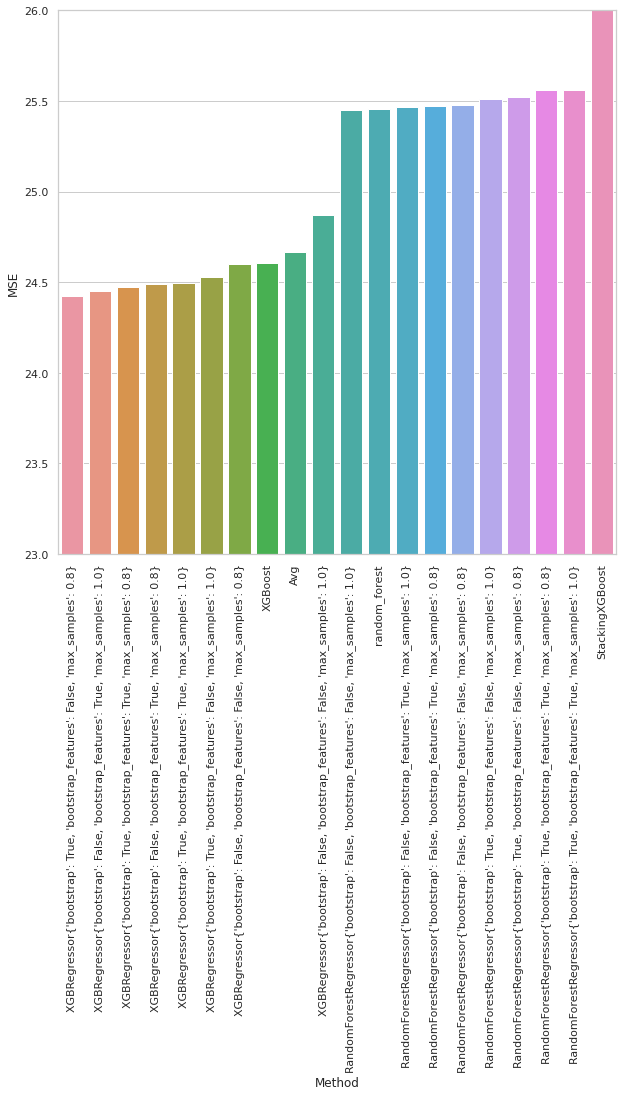

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
ax = sns.barplot(x="Method", y="MSE", data=results_df)
ax= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.ylim(23, 26)

By plotting this plot I could see that the one with higher out of sample accuracy was the XGBoost with stacking (XGBoost as metalearner), then the XGBoost with boostraps in the features, and then the XGBoost. 

After having pushed all to Kaggle, the one with highest accuracy was XGBoost. Here I attach the results I got for the best ensables mentioned above:
   + XGBoost = 4.41
   + XGBoost Stacking = 4.451
   + XBoost Bagging features boostrap = 4.457